In [195]:
import pandas as pd
import json
import glob
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.dates as md
import pickle as pkl
import xgboost
import shap
from tensorflow import keras
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import StandardScaler
from itertools import combinations, product
from src.colnames import topic_col, emotion_col, style_col, exclude_col
from utils import _pca_transform, plot_volume, plot_style_timeseries

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [196]:
df = pd.read_json('data/topic/data.jsonl', 
                        orient='records',
                        lines=True)

### Overall number of Tweets

In [197]:
style_short = [c for c in df.columns if 'rauh' in c or 'benoit' in c]

In [198]:
summary = df.groupby('entity').aggregate({'created_at': 'min',
                                          'text': 'count'}).reset_index()
summary['end_date'] = '2022-06-29'
summary[['end_date',
         'created_at']] = summary[['end_date',
                                   'created_at']].apply(pd.to_datetime)
summary['n_days'] = (summary['end_date'] - summary['created_at']).dt.days
summary['tweets_per_day'] = (summary['text'] / summary['n_days']).round(2)
summary.columns = ['entity', 'first tweet', '# tweets', 'last tweet', '# days', 'tweets per day']
summary = summary[['entity', '# tweets', 'first tweet', 'last tweet', '# days', 'tweets per day']]

In [5]:
summary

entity  # tweets first tweet last tweet  # days  tweets per day
0  10DowningStreet     11595  2008-03-26 2022-06-29    5208            2.23
1        EUCouncil      5652  2012-12-04 2022-06-29    3494            1.62
2    EU_Commission     29621  2010-06-23 2022-06-29    4389            6.75
3      Europarl_EN     18485  2009-04-30 2022-06-29    4808            3.84
4          IMFNews     19361  2009-03-24 2022-06-29    4845            4.00
5             OECD     13558  2009-03-19 2022-06-29    4850            2.80
6               UN     42664  2008-12-20 2022-06-29    4939            8.64
7              ecb     14948  2010-04-28 2022-06-29    4445            3.36
8          scotgov     12090  2009-06-16 2022-06-29    4761            2.54

### Plot tweet volume

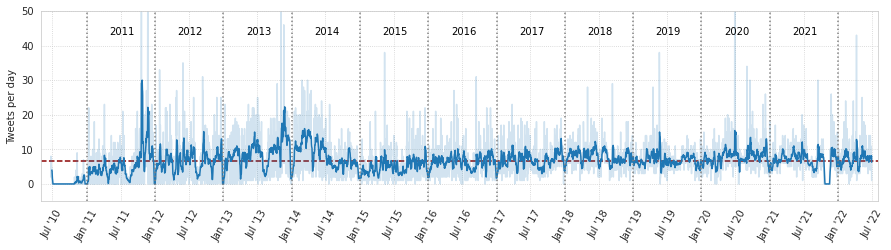

In [7]:
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
plot_volume(df, interactive=False,
            figsize=(15,3.5), 
            plot_smooth_only=False,
            exclude_entities=set(df.entity.unique().tolist()) - set(['EU_Commission']),
            ylim=True, freq='D', roll_window=7)

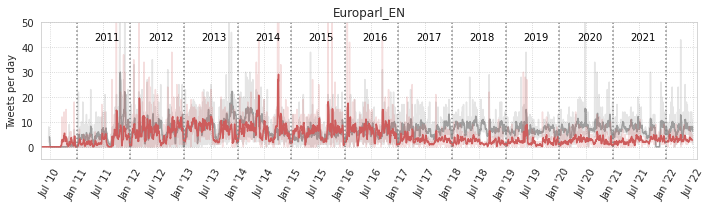

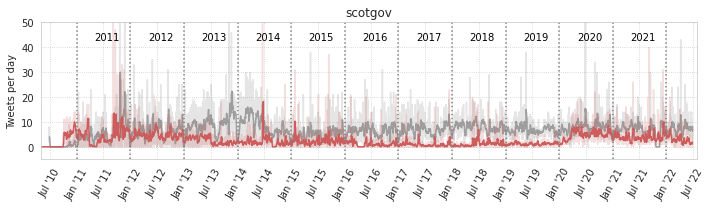

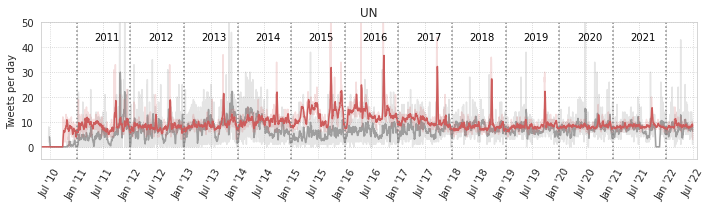

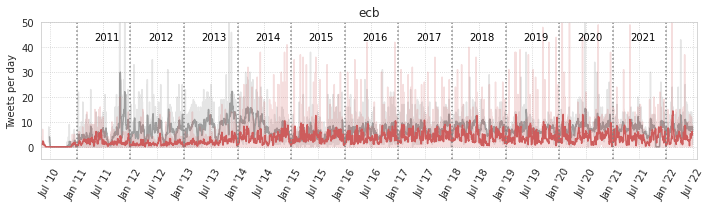

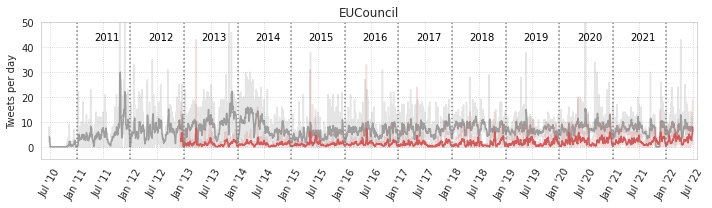

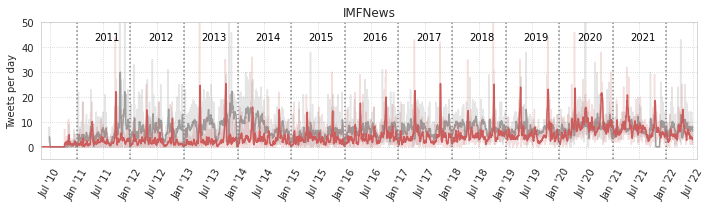

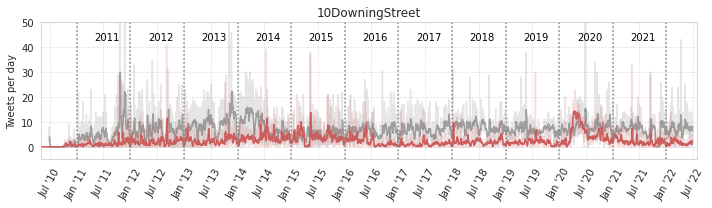

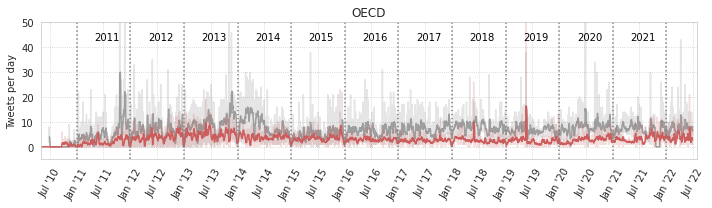

In [8]:
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})
for entity in set(df.entity.unique().tolist()) - set(['EU_Commission']):
    plot_volume(df, interactive=False,
                figsize=(10,3), 
                plot_smooth_only=False,
                exclude_entities=set(df.entity.unique().tolist()) - set(['EU_Commission', entity]),
                ylim=True, freq='D', roll_window=7,
                multiple=True, colors=['grey', 
                                       'indianred'], 
                savename=entity)

## Style

#### Qualitative style comparison

In [199]:
df['n_mentions'] = df['text'].replace('[^@]','', regex=True).str.len()
df['n_hashtag'] = df['text'].replace('[^#]','', regex=True).str.len()
for c in ['n_hashtag', 'n_mentions', 'n_emojis']:
    df[c] = df[c] / df['benoit_sentence-length-words']

In [200]:
df['year'] = df['created_at'].apply(lambda x: x.year)
df['month'] = df['created_at'].apply(lambda x: x.month)

In [201]:
style_targets = [c for c in df.columns if any(['rauh' in c, 
                                               'benoit' in c, 
                                               'alpha_ratio' in c])] + \
                ['n_hashtag', 'n_mentions', 'is_link', 'n_emojis']
sentiment_targets = [c for c in df.columns if 'sentiment' in c]
categories = ['multimodal', 'word complexity', 'action', 'readability',
              'readability', 'overall length', 'sentence complexity',
              'sentence complexity', 'word complexity', 'word complexity',
              'action', 'multimodal', 'multimodal', 'multimodal', 'multimodal',
              'sentiment', 'sentiment', 'sentiment']
mapdict = dict(zip(style_targets+sentiment_targets, categories))

In [202]:
new_names = ['% alphanumeric', 
             'frequency',
             'verb-to-noun ratio', 
             'Flesch-Kincaid Grade',
             'Flesch reading ease',
             '# words', 
             'sentence length (words)', 
             'sentence length (chars)', 
             'word length (syllables)',
             'word length (chars)', 
             '% nouns', 
             '% hashtag', '% mentions', 
             'has link', '% emojis',
             'negative sentiment', 'neutral sentiment', 'positive sentiment']

In [203]:
param_categories = ['alpha', 'sentence complexity', 'action', 
                    'readability', 'sentence complexity', 
                    'sentence complexity', 'word complexity', 
                    'word complexity', 
                    'alpha', 'alpha', 'alpha', 'alpha', 
                    'sentiment', 'sentiment', 'sentiment', 
                    'word complexity', 'readability', 'action']
sort_entities = ['10DowningStreet', 'scotgov', 
                 'UN', 'Europarl_EN', 'EUCouncil', 
                 'ecb', 'IMFNews', 'OECD']

In [204]:
df_standard = df.copy()
#for c in style_targets:
#    df_standard[c] = (df_standard[c] - df_standard[c].mean()) / df_standard[c].std()
df_standard = df_standard.rename(dict(zip(style_targets+sentiment_targets,
                                          new_names)), axis=1)

### Within EU Commission, over time

In [205]:
df_reduced = df_standard.copy()
df_reduced = df_reduced.dropna(subset=new_names)
df_reduced = df_reduced.drop(['% nouns'], axis=1)

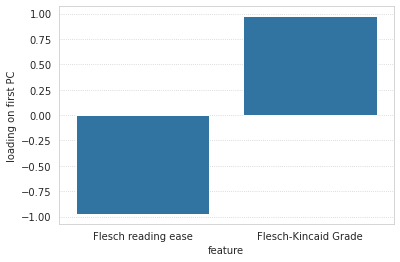

[0.94891961 0.05108039]


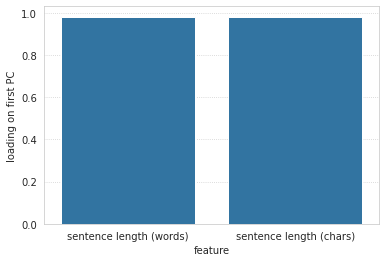

[0.96452659 0.03547341]


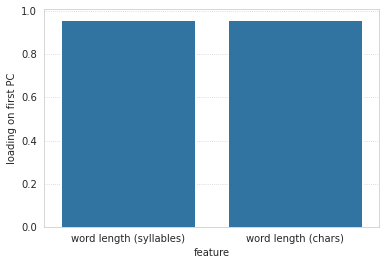

[0.92216651 0.07783349]


In [206]:
import numpy as np
from sklearn.decomposition import PCA
reduce_sets = [['Flesch reading ease',
                'Flesch-Kincaid Grade'],
               ['sentence length (words)',
                'sentence length (chars)'],
               ['word length (syllables)',
                'word length (chars)']]
new_names = ['reading complexity', 'sentence length', 'word length']

for rs, nn in zip(reduce_sets, new_names):
    X = df_reduced[rs].dropna()
    X = StandardScaler().fit_transform(X)
    pca = PCA(n_components=len(rs))
    pca.fit(X)
    df_reduced[nn] = pca.transform(X)[:,0]
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    loading_matrix = pd.DataFrame(loadings, columns=[f'PC{i}' 
                                                     for i in range(len(rs))], index=rs)
    loading_matrix = loading_matrix.reset_index().melt(id_vars='index')
    sns.barplot(data=loading_matrix[loading_matrix['variable']=='PC0'], 
                x='index', y='value', color=sns.color_palette()[0])
    plt.xlabel('feature')
    plt.ylabel('loading on first PC')
    plt.show()
    print(pca.explained_variance_ratio_)

In [207]:
new_cols = ['reading complexity',
             'verb-to-noun ratio',
             '# words', # standalone
             'sentence length',
             'word length',
             'frequency',
             'negative sentiment', 'neutral sentiment', 'positive sentiment',
             '% alphanumeric', 
             '% hashtag', '% mentions', 
             'has link', '% emojis']

In [186]:
df_reduced[['entity', 'created_at'] + new_cols]

entity created_at  reading complexity  verb-to-noun ratio  \
0               scotgov 2020-04-16           -0.065646            0.418241   
1               scotgov 2020-04-16           -0.824320            0.314671   
2               scotgov 2020-04-16           -0.118892            0.245625   
3               scotgov 2020-04-15           -1.054684           -0.193762   
4               scotgov 2020-04-15            0.244304           -0.160531   
...                 ...        ...                 ...                 ...   
167969  10DowningStreet 2011-08-15            0.593136           -0.444840   
167970  10DowningStreet 2011-08-13            0.091719           -0.617456   
167971  10DowningStreet 2011-08-12            1.548997           -0.790072   
167972  10DowningStreet 2011-08-11            0.543899            0.936089   
167973  10DowningStreet 2011-08-11           -1.563933           -0.099607   

         # words  sentence length  word length  frequency  negative sentiment  \
0      -0.260981        -0.798423     0.723238   0.067971            0.047496   
1       2.183703         0.129915    -1.226203  -0.670482            0.683533   
2       0.735002         0.263659    -0.382899   0.240430            0.010998   
3       2.002616         0.051555    -1.183950  -0.082899            0.110060   
4       2.817510         2.084955    -1.708847  -0.459027            0.005134   
...          ...              ...          ...        ...                 ...   
167969 -0.170437         1.154226    -0.374940   0.657578            0.250268   
167970 -0.351525         0.854375    -0.216184   1.420698            0.040228   
167971 -0.532612         0.748838     1.671765  -0.493500            0.041448   
167972 -0.804244        -0.175925     0.608026   0.112014            0.499823   
167973  0.463370        -0.371445    -1.896483   1.360954            0.505404   

        neutral sentiment  positive sentiment  % alphanumeric  % hashtag  \
0                0.868780            0.083724        0.073793   0.290939   
1                0.289146            0.027321       -2.092453   0.497527   
2                0.272406            0.716596       -1.248096   0.540270   
3                0.584169            0.305771       -0.334340  -0.093410   
4                0.461732            0.533133       -1.177435  -0.742001   
...                   ...                 ...             ...        ...   
167969           0.693871            0.055860        1.124094  -0.742001   
167970           0.915099            0.044674        0.500763  -0.742001   
167971           0.890415            0.068137        1.423772  -0.122237   
167972           0.477106            0.023070        2.083065  -0.742001   
167973           0.398348            0.096248        0.381665  -0.026888   

        % mentions  has link  % emojis  
0         2.283887  0.314431 -0.013088  
1        -0.499906  0.314431 -0.008799  
2         0.364030  0.314431 -0.010460  
3        -0.499906  0.314431 -0.010271  
4         0.463714  0.314431 -0.012772  
...            ...       ...       ...  
167969   -0.499906 -3.180327 -0.013088  
167970   -0.499906  0.314431 -0.013088  
167971   -0.499906  0.314431 -0.013088  
167972   -0.499906  0.314431 -0.013088  
167973   -0.499906 -3.180327 -0.013088  

[164299 rows x 16 columns]

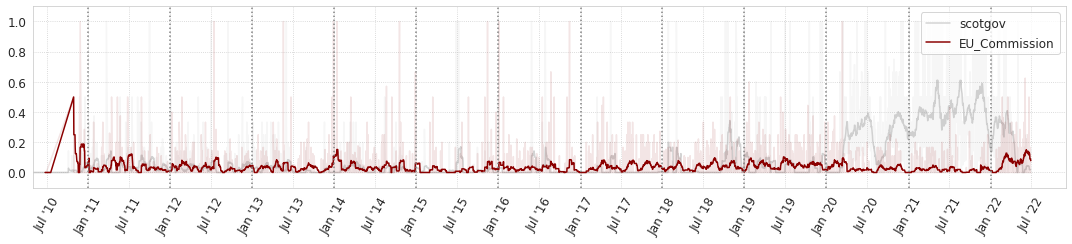

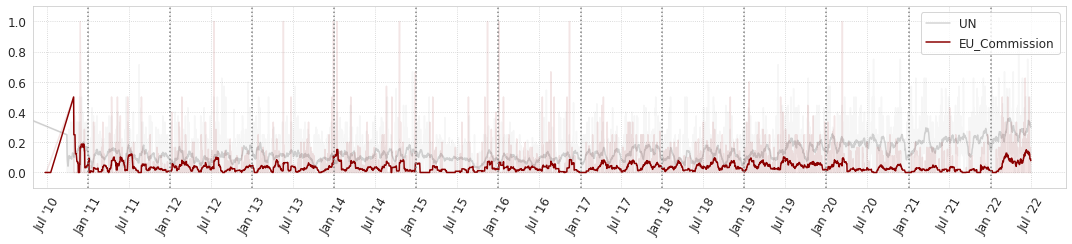

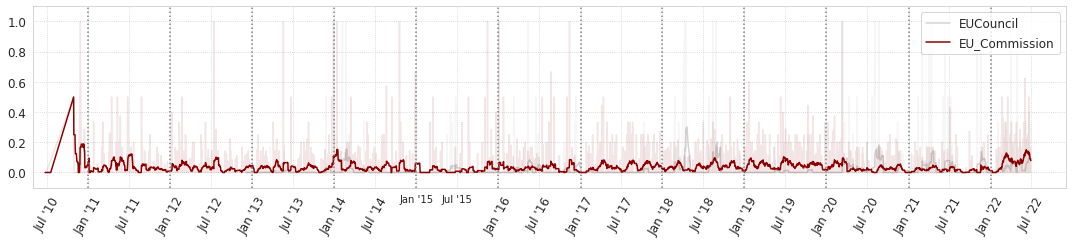

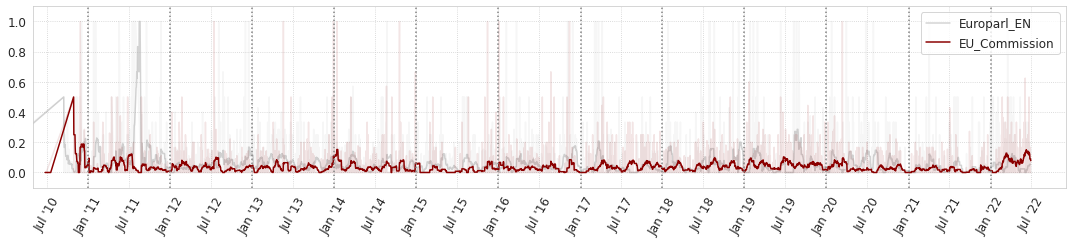

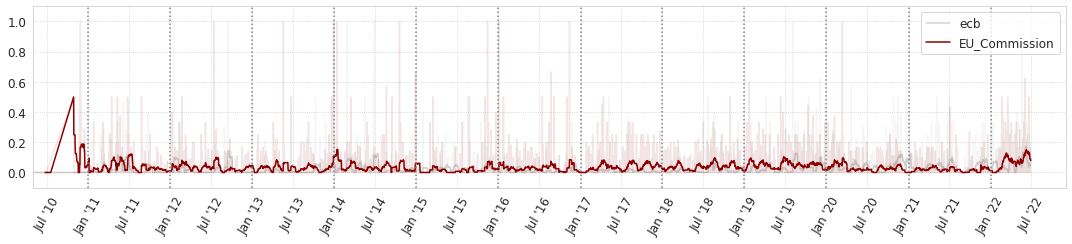

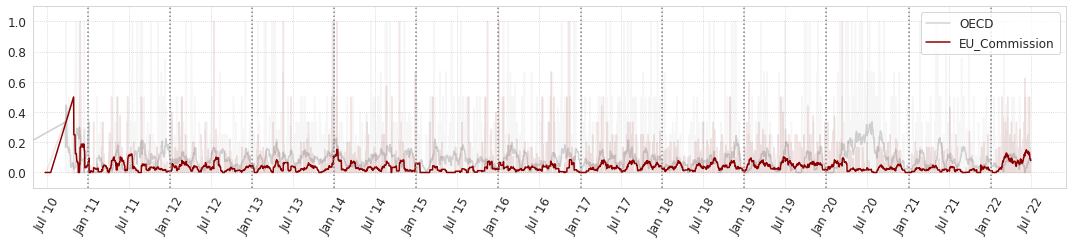

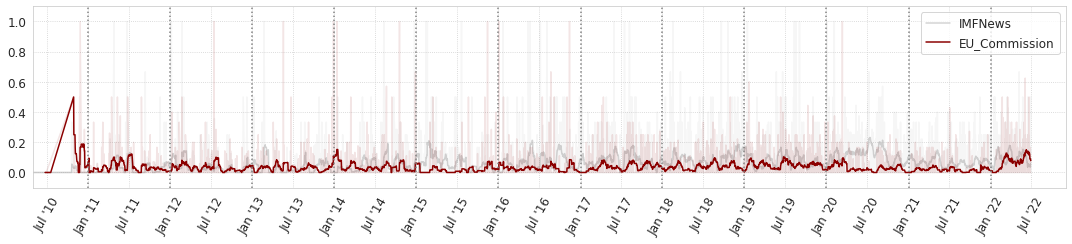

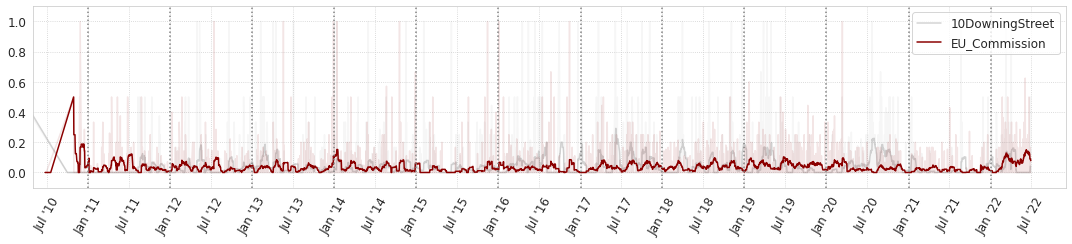

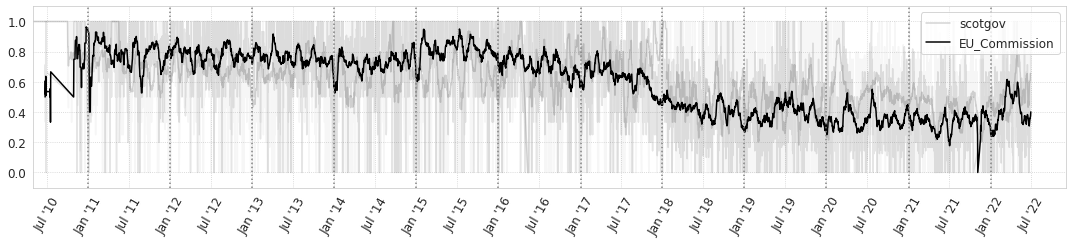

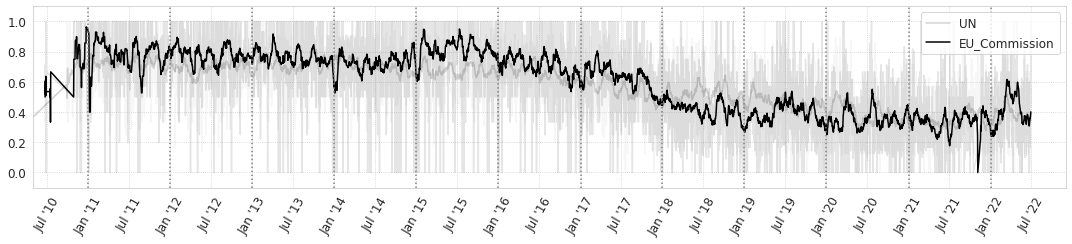

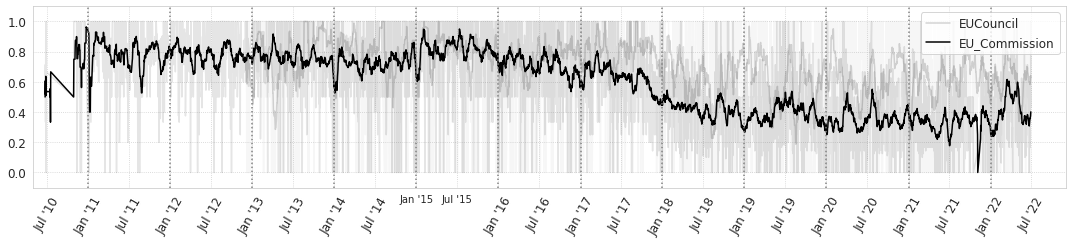

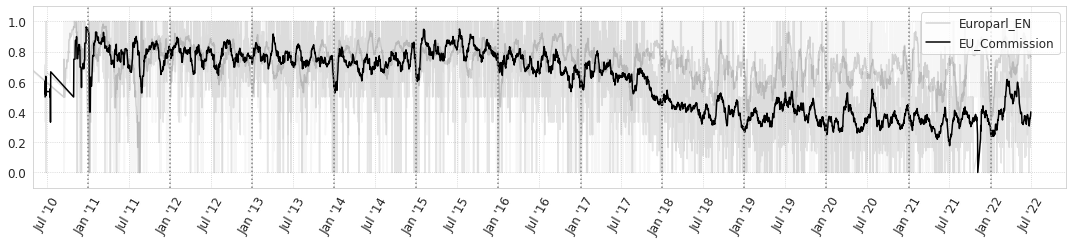

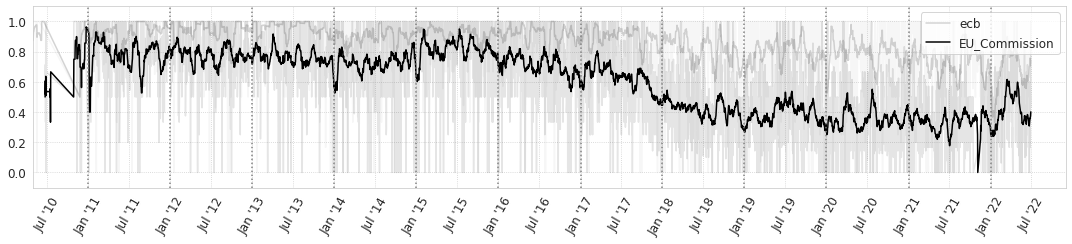

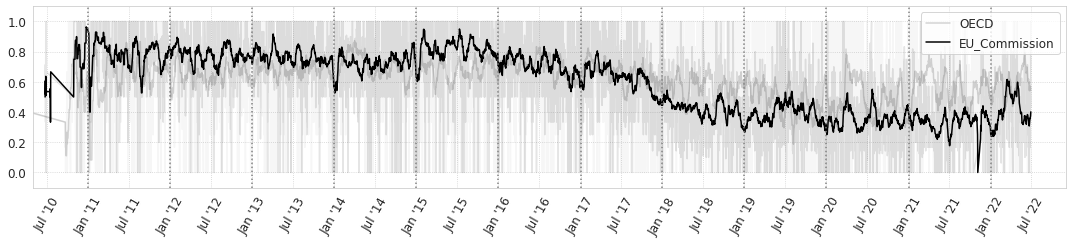

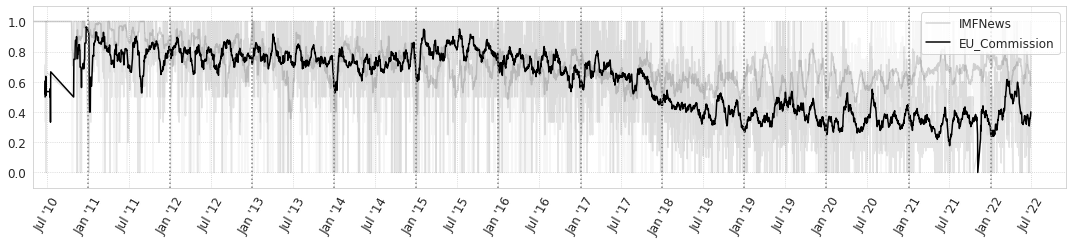

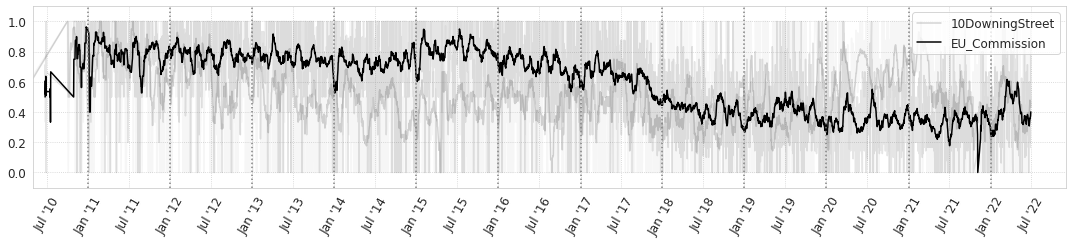

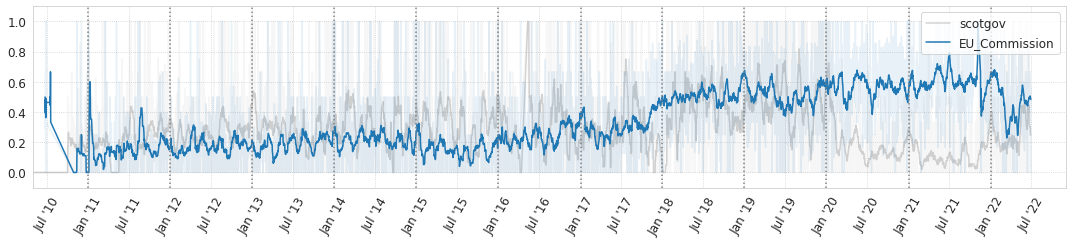

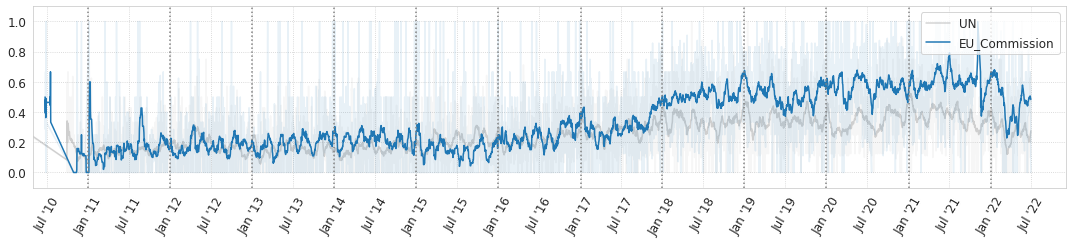

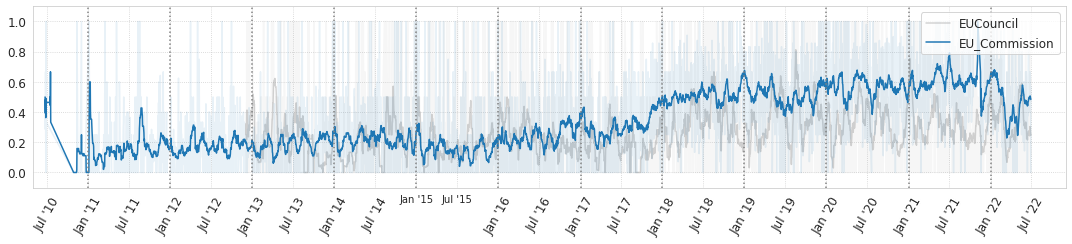

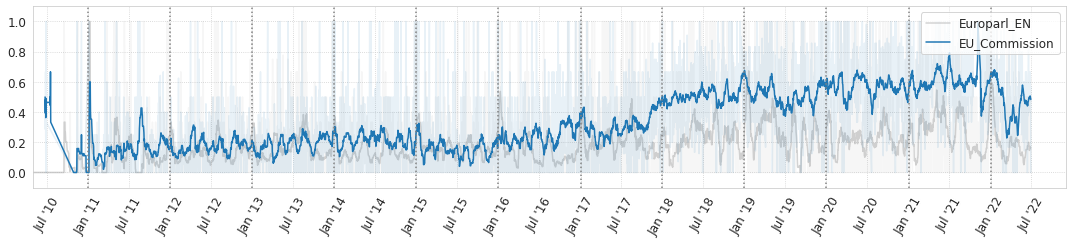

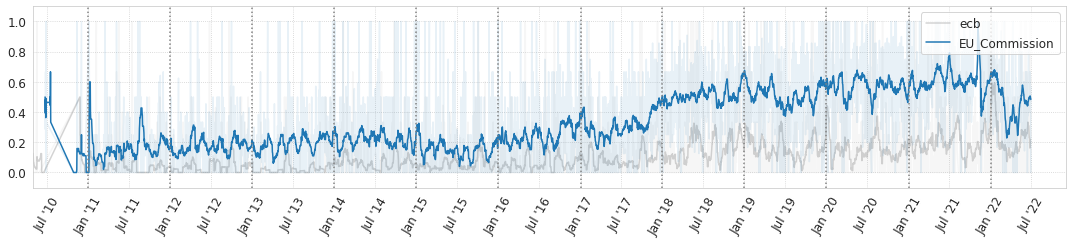

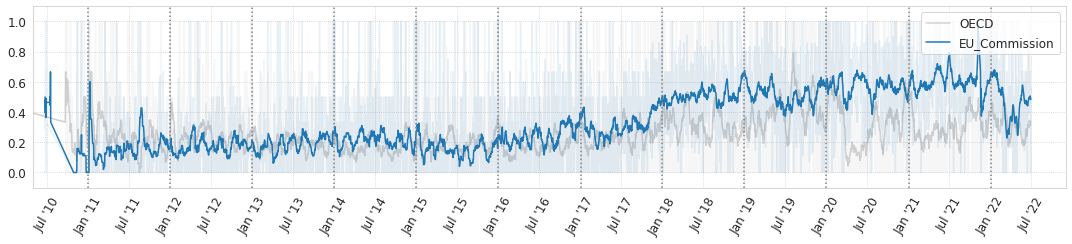

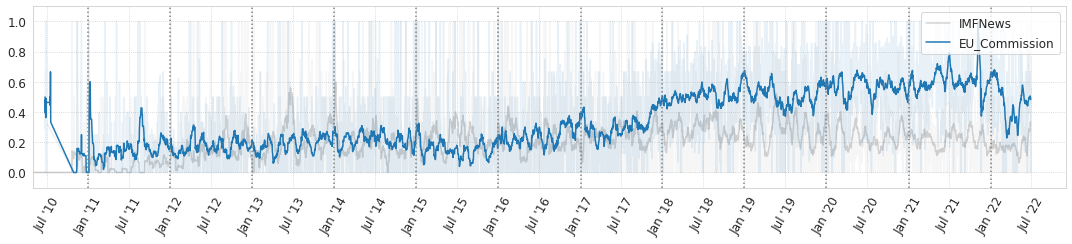

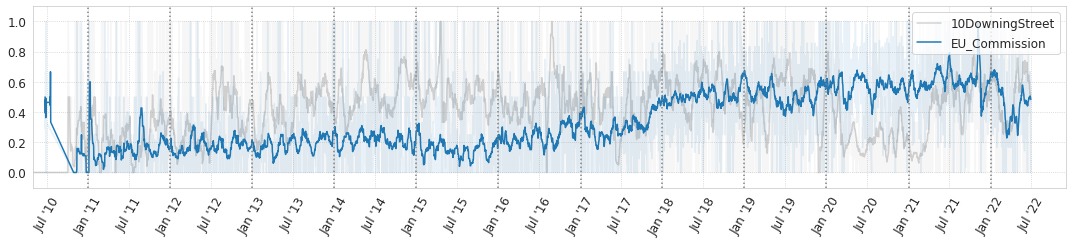

In [187]:
for c in [n for n in new_cols if 'sentiment' in n]:
    for e in df_reduced.entity.unique():
        if e != 'EU_Commission':
            if 'positive' in c:
                color = sns.color_palette()[0]
            elif 'neutral' in c:
                color = 'black'
            else:
                color = 'darkred'
            plot_style_timeseries(df_reduced, 
                                  entities=[e,'EU_Commission'],
                                  colors=['darkgrey', color],
                                  metric=c,
                                  freq='D', 
                                  roll_window=21,
                                  normalized=False,
                                  savename=f'sentiment_timeseries/{c}_{e}',
                                  plot_smooth_only=False,
                                  interactive=False,
                                  title=f'{c} - {e}',
                                  no_horizontal=True,
                                  ylim=(-0.1,1.1),
                                  figsize=(15,3.5))

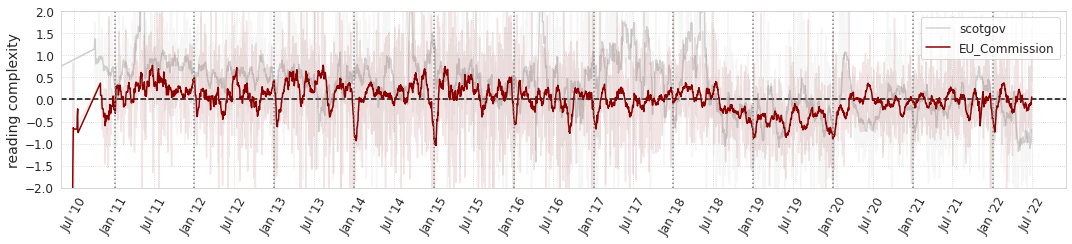

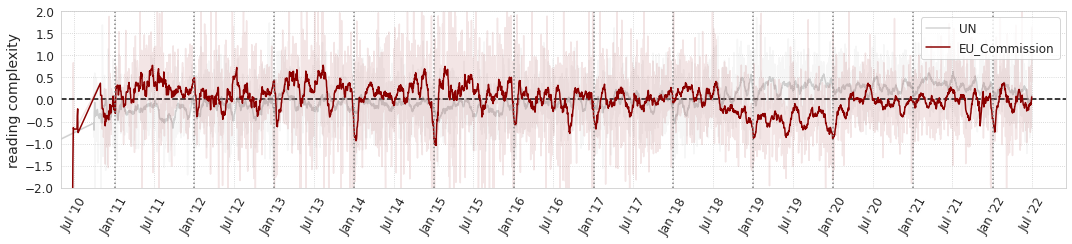

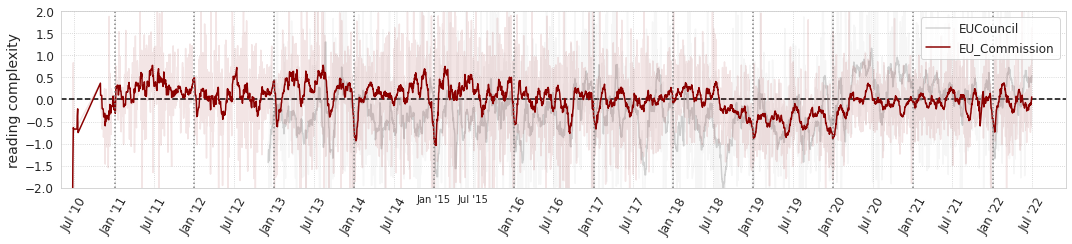

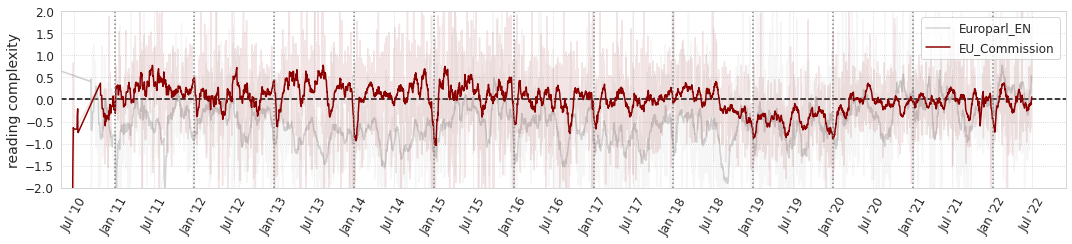

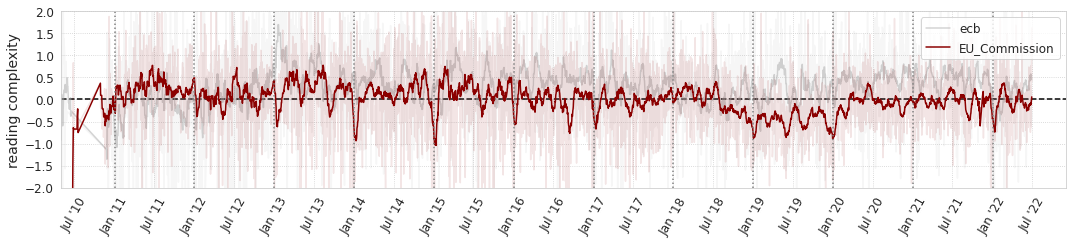

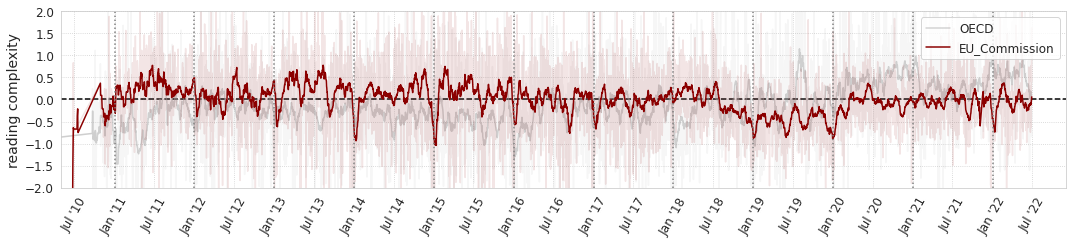

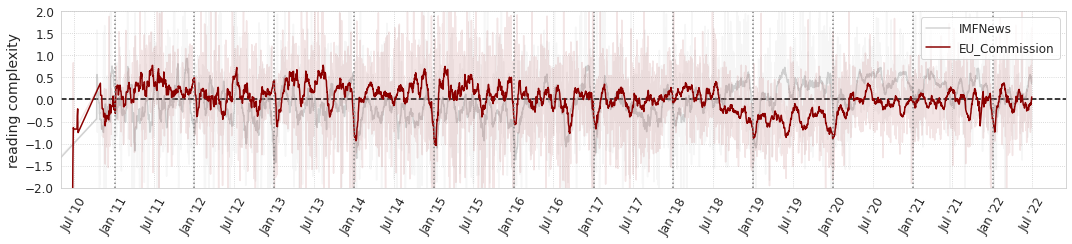

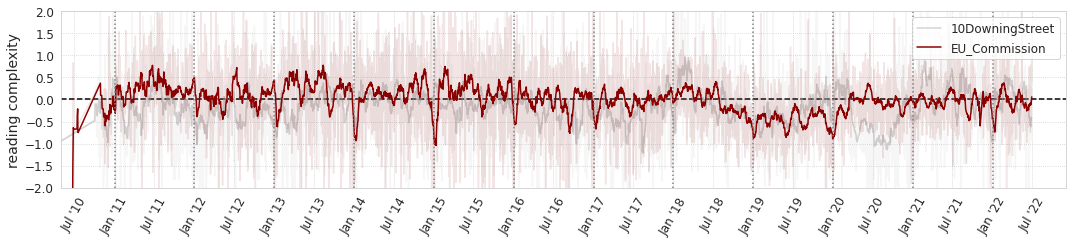

In [212]:
for c in ['reading complexity']:
    for e in df_reduced.entity.unique():
        if e != 'EU_Commission':
            plot_style_timeseries(df_reduced, 
                                  entities=[e,'EU_Commission'],
                                  colors=['darkgrey', 'darkred'],
                                  metric=c,
                                  freq='D', 
                                  roll_window=21,
                                  normalized=False,
                                  savename=f'style_timeseries/{c}_{e}',
                                  plot_smooth_only=False,
                                  interactive=False,
                                  title=f'{c} - {e}',
                                  no_horizontal=False,
                                  ylim=(-2,2),
                                  figsize=(15,3.5))

In [86]:
grouped = df_reduced[df_reduced['entity']=='EU_Commission'].groupby('year')[new_cols].agg(np.nanmean).reset_index()

In [87]:
grouped_long = grouped.melt(id_vars='year')

In [21]:
grouped_long['category'] = grouped_long['variable'].map(mapdict)
grouped_long['variable'] = grouped_long['variable'].map(dict(zip(style_targets+sentiment_targets,
                                                                 new_names)))
grouped = grouped.rename(dict(zip(style_targets+sentiment_targets, new_names)),
                         axis=1)

In [90]:
grouped

year  reading complexity  verb-to-noun ratio   # words  sentence length  \
0   2010           -0.429290           -0.157402 -0.352656        -0.374863   
1   2011            0.298127           -0.338156 -0.656757        -0.073203   
2   2012            0.115303           -0.212515 -0.654367        -0.238262   
3   2013            0.418747           -0.286204 -0.717065        -0.328677   
4   2014            0.297677           -0.249829 -0.720809        -0.401063   
5   2015            0.388457           -0.219142 -0.769474        -0.482599   
6   2016            0.123717           -0.143508 -0.640038        -0.389322   
7   2017            0.084728            0.004194 -0.214208        -0.089451   
8   2018           -0.035787            0.033051  1.235232         0.509440   
9   2019           -0.462453            0.054537  1.446495        -0.004159   
10  2020           -0.070116            0.032773  1.687035         0.221705   
11  2021            0.028059            0.051739  1.821933         0.297245   
12  2022            0.036809            0.034614  1.869442         0.345895   

    word length  frequency  negative sentiment  neutral sentiment  \
0     -0.377432   0.279595           -0.177544           0.159586   
1      0.400912  -0.194865           -0.167495           0.337746   
2      0.333871  -0.091256           -0.176555           0.281799   
3      0.810924  -0.038602           -0.199604           0.252957   
4      0.773682  -0.056216           -0.212817           0.293054   
5      0.929877   0.003618           -0.288436           0.470753   
6      0.462697  -0.049231           -0.257519           0.205768   
7      0.095268   0.092426           -0.214660          -0.046940   
8     -0.533750   0.222949           -0.212990          -0.642744   
9     -0.779743   0.269719           -0.163713          -0.680034   
10    -0.391680   0.088627           -0.280416          -0.715358   
11    -0.385826   0.013576           -0.312360          -0.772275   
12    -0.367838   0.066154           -0.041517          -0.673127   

    positive sentiment  % alphanumeric  % hashtag  % mentions  has link  \
0            -0.026863       -0.583077   1.708815   -0.499906 -1.083472   
1            -0.196216       -0.102033   0.522591   -0.415369 -0.121974   
2            -0.139083       -0.056611   0.547102   -0.073789  0.012508   
3            -0.097331       -0.151696   0.695656    0.302419  0.137217   
4            -0.125091       -0.106287   0.384715    0.344429  0.177243   
5            -0.236695       -0.395400   0.524745    0.493861  0.279269   
6            -0.015500       -0.343140   0.230838    0.090860  0.298954   
7             0.186496       -0.213998   0.060122    0.039637  0.268356   
8             0.729240       -0.102874  -0.015940   -0.192388  0.259226   
9             0.730304       -0.316600  -0.075259   -0.300647  0.254321   
10            0.840645       -0.281803   0.215634   -0.126472 -0.478395   
11            0.913976       -0.451172   0.225147   -0.230913 -0.910227   
12            0.642226       -0.347135   0.033498   -0.094359 -1.043747   

    % emojis  
0  -0.299929  
1  -0.299929  
2  -0.299929  
3  -0.299929  
4  -0.299929  
5  -0.294726  
6  -0.064413  
7   0.260414  
8   0.311305  
9   0.455478  
10  0.647539  
11  1.114602  
12  1.037398

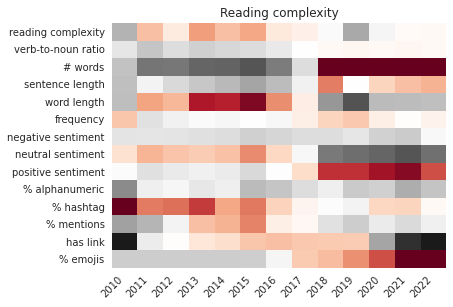

In [92]:
from sklearn.preprocessing import MinMaxScaler

# for c in grouped_long.category.unique():
# sub_grouped = grouped # [grouped_long[grouped_long['category']==c].variable.unique().tolist()]
plt.subplots(figsize=(6,0.3*len(grouped.columns)))
sns.heatmap(grouped.drop('year', axis=1).T, cmap='RdGy_r', center=.0, cbar=False,
            vmax=1, vmin=-1)
plt.xticks(ticks=range(grouped.year.nunique()),
           labels=grouped.year.unique(),
           rotation=45)
plt.yticks(rotation=0)
plt.title(c.capitalize())
plt.savefig(f'figs/heatmap_{c}.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
df_standard

In [33]:
import numpy as np
from sklearn.decomposition import PCA

X = df_standard[['negative sentiment', 
                 'neutral sentiment',
                 'positive sentiment']].dropna()
pca = PCA(n_components=3)
pca.fit(X)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[5.99815248e-01 4.00184752e-01 2.92144307e-15]
[5.49780229e+02 4.49066476e+02 3.83688764e-05]


In [25]:
pca.explained_variance_ratio_

array([0.74216127, 0.23825776, 0.01958097])

In [17]:
# sentence length (words)
# sentence length (chars)
# number of words

#### Similarity with different institutions, over time

In [17]:
# Overall similarity over time (Euclidean distance with other agencies)
# Overall discriminability (at three time steps)

#### Qualitative plot: overall similarity, per trait

In [394]:
bow_targets = [c for c in df_standard.columns if 'bow_500' in c]

alpha_targets = ['is_link',
                 'n_hashtag',
                 'n_mentions',
                 'n_emojis']

action_targets = ['rauh_verb-to-noun', 
                  'benoit_prop-noun']

sentence_targets = ['benoit_overall-length', 
                    'benoit_sentence-length-words',
                    'benoit_sentence-length-characters']

word_targets = ['rauh_frequency',
                'benoit_word-length-syllables',
                'benoit_word-length-characters']

readability_targets = ['rauh_readability', 'benoit_readability']

feature_set_names = ['style (all)', 
                     #'sentiment', 
                     #'Multimodal',
                     #'Action', 
                     #'sentence complexity',
                     #'word complexity', 
                     #'readability'
                    ]

feature_sets = [style_targets, 
                #sentiment_targets,
                #alpha_targets, 
                #action_targets,
                #sentence_targets, 
                #word_targets, 
                #readability_targets
               ]

In [395]:
perfs = []
for r in range(5):
    print(f'Run {r}')
    
    for i in df_standard.year.unique():
        print(f'Year {i}')

        for feature, name in zip(feature_sets, feature_set_names):
            for e in set(df_standard.entity.unique()) - set(['EU_Commission']):

                scaler = StandardScaler()

                # Make datasets
                trains = []; vals = [];

                try:
                    for en in [e, 'EU_Commission']:
                            trains.append(df_standard[(df_standard['year']==i) & 
                                                    (df_standard['entity']==en)].sample(1000, replace=True))
                            vals.append(df_standard[(df_standard['year']==i) & 
                                                  (df_standard['entity']==en)].sample(1000, replace=True))

                    trains = pd.concat(trains).sample(frac=1)
                    train_X = scaler.fit_transform(trains[feature].fillna(0).values)
                    train_y = trains['entity'].map({e: 1.0, 'EU_Commission': 0.0})
                    vals = pd.concat(vals).sample(frac=1)
                    val_X = scaler.fit_transform(vals[feature].fillna(0).values)
                    val_y = vals['entity'].map({e: 1.0, 'EU_Commission': 0.0})

                    # Define model
                    inputs = keras.Input(shape=(len(feature)))
                    x = keras.layers.Dense(units=len(feature))(inputs)
                    x = keras.layers.Dense(units=len(feature))(x)
                    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
                    model = keras.Model(inputs, outputs)
                    model.compile(optimizer='rmsprop', 
                                  loss=keras.losses.BinaryCrossentropy(from_logits=False),
                                  metrics='accuracy')

                    # Fit and evaluate
                    model.fit(train_X, train_y, epochs=100, 
                              verbose=0,
                              validation_split=.2, 
                              callbacks=keras.callbacks.EarlyStopping(patience=3))

                    # Plot
                    perfs.append((name, e, 
                                  round(model.evaluate(val_X, val_y, verbose=0)[1],3), 
                                  i, r))

                except:
                    continue
                    
perf_df = pd.DataFrame(perfs, columns=['name', 'entity', 'score', 'year', 'run'])

Run 0
Year 2020
Year 2009
Year 2011
Year 2022
Year 2012
Year 2019
Year 2018
Year 2021
Year 2017
Year 2013
Year 2014
Year 2010
Year 2015
Year 2016
Year 2008
Run 1
Year 2020
Year 2009
Year 2011
Year 2022
Year 2012
Year 2019
Year 2018
Year 2021
Year 2017
Year 2013
Year 2014
Year 2010
Year 2015
Year 2016
Year 2008
Run 2
Year 2020
Year 2009
Year 2011
Year 2022
Year 2012
Year 2019
Year 2018
Year 2021
Year 2017
Year 2013
Year 2014
Year 2010
Year 2015
Year 2016
Year 2008
Run 3
Year 2020
Year 2009
Year 2011
Year 2022
Year 2012
Year 2019
Year 2018
Year 2021
Year 2017
Year 2013
Year 2014
Year 2010
Year 2015
Year 2016
Year 2008
Run 4
Year 2020
Year 2009
Year 2011
Year 2022
Year 2012
Year 2019
Year 2018
Year 2021
Year 2017
Year 2013
Year 2014
Year 2010
Year 2015
Year 2016
Year 2008


In [396]:
perf_all = perf_df.copy()
perf_all.to_json('logs/classifiers_time.jsonl', orient='records', lines=True)

In [441]:
perf_df = perf_df.groupby(['name', 'entity', 'year']).score.mean().reset_index()
perf_wide = pd.pivot(perf_df[perf_df['year']>=2012], index=['name','entity'], 
                     columns='year', values='score').reset_index()

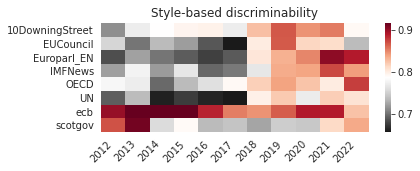

In [443]:
for c in perf_df['name'].unique():
    target_data = perf_wide[(perf_wide['name']==c) ]
    target_data = target_data.sort_values(by='entity')
    entities = target_data.entity.tolist()
    target_data = target_data.drop(['name', 'entity'], axis=1)
    plt.subplots(figsize=(6,2))
    sns.heatmap(target_data, cmap='RdGy_r', robust=True, square=False)
    plt.xticks(ticks=range(grouped.year.nunique()-2),
               labels=sorted(set(grouped.year.unique()) - set([2010,2011])),
               rotation=45, ha='center')
    plt.yticks(ticks=np.arange(0.5,8.5,1), labels=entities, rotation=0)
    plt.title('Style-based discriminability')
    plt.xlabel('')
    plt.show()

### Qualitative comparison

In [452]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

ests = []
for t in style_targets + sentiment_targets:
    scaler = StandardScaler()
    new_t_name = t.replace('-','_')
    data = df[df['year']>=2018].rename({t: new_t_name}, axis=1).fillna(0)
    data[new_t_name] = scaler.fit_transform(data[[new_t_name]])
    formula = f"{new_t_name} ~ C(entity, Treatment(reference='EU_Commission')) + {' + '.join(topic_col)}" # added topics for control
    
    # Specify model
    mod = smf.rlm(formula, data=data, M=sm.robust.norms.HuberT())
    
    # Freq workflow
    res = mod.fit()
    
    # Save estimates
    est_df = pd.DataFrame(res.params, columns=['param'])
    est_df['predictor'] = est_df.index.str.replace(r"C\(entity, Treatment\(reference='EU_Commission'\)\)\[T\.", "", 
                                                   regex=True)
    est_df['predictor'] = est_df['predictor'].str.replace(r"\]", "", regex=True)
    est_df['target'] = t
    est_df['p_val'] = res.pvalues.values
    est_df = est_df[~est_df['predictor'].isin(topic_col)]
    est_df = est_df.reset_index(drop=True)
    est_df = est_df[est_df['predictor']!='Intercept']
    ests.append(est_df)
    
# Make joint dataset
ests = pd.concat(ests)
ests['param'] = ests['param'] * (ests['p_val']<0.05).astype(int)
ests.drop('p_val', axis=1, inplace=True)

In [453]:
ests['category'] = ests['target'].map(mapdict)
ests['target'] = ests['target'].map(dict(zip(style_targets+sentiment_targets, new_names)))


In [454]:
ests_wide = ests.pivot(index='predictor',
                       columns='target', values='param')

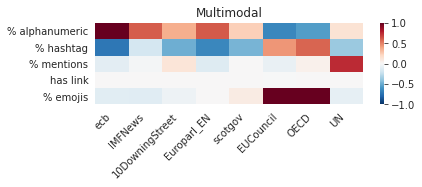

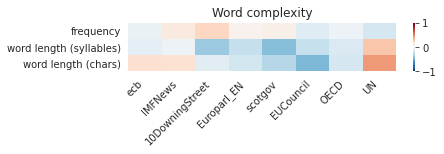

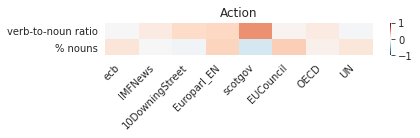

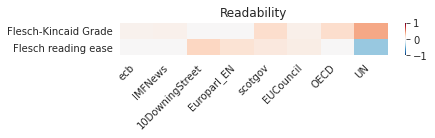

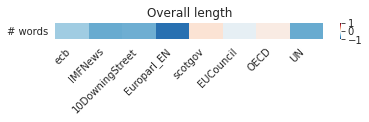

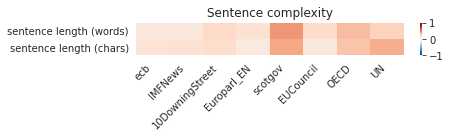

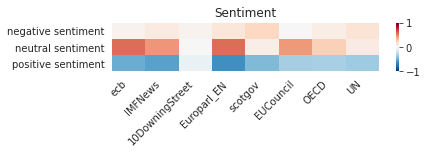

In [458]:
for c in ests.category.unique():
    sub_grouped = ests_wide[ests[ests['category']==c].target.unique().tolist()]
    # sub_grouped = (sub_grouped>0).astype(int)
    #sub_grouped=ests_wide[targets]
    plt.subplots(figsize=(6,0.3*len(sub_grouped.columns)))
    sub_grouped = sub_grouped.T[['UN', 'OECD', 'EUCouncil', 'scotgov', 'Europarl_EN', 
                                 '10DowningStreet', 'IMFNews', 'ecb'][::-1]]
    sns.heatmap(sub_grouped, cmap='RdBu_r', center=.0, vmin=-1, vmax=1)
    plt.ylabel('')
    plt.xlabel('')
    plt.yticks(rotation=0)
    plt.xticks(rotation=45, ha='right')
    plt.title(c.capitalize())
    plt.savefig(f'figs/hm_{c}.png', dpi=300, bbox_inches='tight')
    plt.show()

### Results of predictive models

In [7]:
# d = json.load(open('logs/transformers/sum_count.json'))
d = json.load(open('logs/engagement/sum_count.json'))

In [8]:
tr_res = pd.DataFrame(d).sort_values(by='test_r2')
tr_res['model'] = tr_res['model'].str.replace('sum_count_', '')

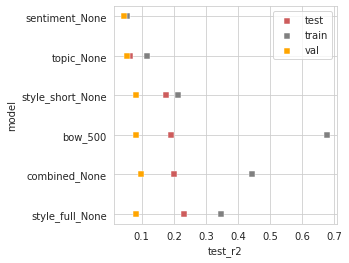

In [9]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(4,4))
sns.scatterplot(data=tr_res, x='test_r2', y='model', label='test', color='indianred', marker='s')
sns.scatterplot(data=tr_res, x='train_r2', y='model', label='train', color='grey', marker='s')
sns.scatterplot(data=tr_res, x='val_r2', y='model', label='val', color='orange', marker='s')
plt.show()

In [10]:
dfs = []
for metric in ['sum']:
    fs = glob.glob(f'logs/*/{metric}_count/pred*.pkl')
    for f in fs:
        print(f)
        f_df = pd.read_pickle(f)
        f_df['metric'] = metric
        dfs.append(f_df)
    metrics = pd.concat(dfs, ignore_index=True)
    

logs/engagement/sum_count/pred_sum_count_topic_None_train.pkl
logs/engagement/sum_count/pred_sum_count_style_short_None_train.pkl
logs/engagement/sum_count/pred_sum_count_sentiment_None_test.pkl
logs/engagement/sum_count/pred_sum_count_topic_None_val.pkl
logs/engagement/sum_count/pred_sum_count_bow_500_test.pkl
logs/engagement/sum_count/pred_sum_count_sentiment_None_val.pkl
logs/engagement/sum_count/pred_sum_count_style_short_None_val.pkl
logs/engagement/sum_count/pred_sum_count_combined_None_test.pkl
logs/engagement/sum_count/pred_sum_count_combined_None_train.pkl
logs/engagement/sum_count/pred_sum_count_bow_500_train.pkl
logs/engagement/sum_count/pred_sum_count_style_short_None_test.pkl
logs/engagement/sum_count/pred_sum_count_style_full_None_train.pkl
logs/engagement/sum_count/pred_sum_count_topic_None_test.pkl
logs/engagement/sum_count/pred_sum_count_combined_None_val.pkl
logs/engagement/sum_count/pred_sum_count_style_full_None_val.pkl
logs/engagement/sum_count/pred_sum_count_bow_5

In [11]:
spears = metrics.groupby(['metric', 'split',
                          'model_name'])[['label', 
                                          'prediction']].apply(lambda x: x.corr('spearman').iloc[0,1]).reset_index()
spears = spears.rename({0: 'spearman_cor'}, axis=1)

In [27]:
spears

metric  split                                         model_name  \
3     sum   test  sum_count_distilbert-base-uncased_lr-0.01_wdec...   
23    sum    val  sum_count_distilbert-base-uncased_lr-0.01_wdec...   
13    sum  train  sum_count_distilbert-base-uncased_lr-0.01_wdec...   
14    sum  train  sum_count_distilbert-base-uncased_lr-1e-05_wde...   
4     sum   test  sum_count_distilbert-base-uncased_lr-1e-05_wde...   
24    sum    val  sum_count_distilbert-base-uncased_lr-1e-05_wde...   
26    sum    val                           sum_count_sentiment_None   
16    sum  train                           sum_count_sentiment_None   
6     sum   test                           sum_count_sentiment_None   
9     sum   test                               sum_count_topic_None   
29    sum    val                               sum_count_topic_None   
19    sum  train                               sum_count_topic_None   
28    sum    val                         sum_count_style_short_None   
20    sum    val                                  sum_count_bow_500   
8     sum   test                         sum_count_style_short_None   
0     sum   test                                  sum_count_bow_500   
18    sum  train                         sum_count_style_short_None   
27    sum    val                          sum_count_style_full_None   
21    sum    val                            sum_count_combined_None   
7     sum   test                          sum_count_style_full_None   
17    sum  train                          sum_count_style_full_None   
1     sum   test                            sum_count_combined_None   
11    sum  train                            sum_count_combined_None   
2     sum   test  sum_count_distilbert-base-uncased_lr-0.01_wdec...   
22    sum    val  sum_count_distilbert-base-uncased_lr-0.01_wdec...   
12    sum  train  sum_count_distilbert-base-uncased_lr-0.01_wdec...   
10    sum  train                                  sum_count_bow_500   
5     sum   test  sum_count_distilbert-base-uncased_lr-1e-05_wde...   
25    sum    val  sum_count_distilbert-base-uncased_lr-1e-05_wde...   
15    sum  train  sum_count_distilbert-base-uncased_lr-1e-05_wde...   

    spearman_cor  
3       0.032487  
23      0.035013  
13      0.046191  
14      0.304803  
4       0.306303  
24      0.320070  
26      0.488881  
16      0.496221  
6       0.509414  
9       0.564465  
29      0.568801  
19      0.578028  
28      0.670264  
20      0.681547  
8       0.685771  
0       0.695578  
18      0.698524  
27      0.709596  
21      0.729139  
7       0.729663  
17      0.737605  
1       0.746385  
11      0.751553  
2       0.752813  
22      0.753655  
12      0.757291  
10      0.776795  
5       0.839238  
25      0.846386  
15      0.908941

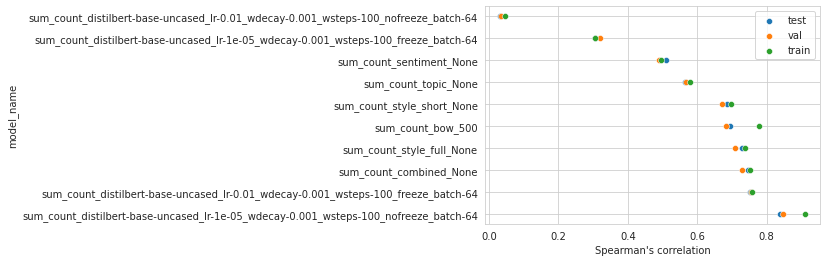

In [12]:
for metric in ['sum']:
    for out_metric in ['spearman_cor']:
        spears = spears.sort_values(by=out_metric, ascending=True)
        for split in ['test',  'val', 'train']:
            sns.scatterplot(data=spears[(spears['split']==split) & \
                                        (spears['metric']==metric)],
                            y='model_name', x='spearman_cor', label=split)
        plt.xlabel('Spearman\'s correlation')
        plt.show()

### Predictive models

***** sum *****
logs/engagement/sum_count/sum_count_combined_None.pkl


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


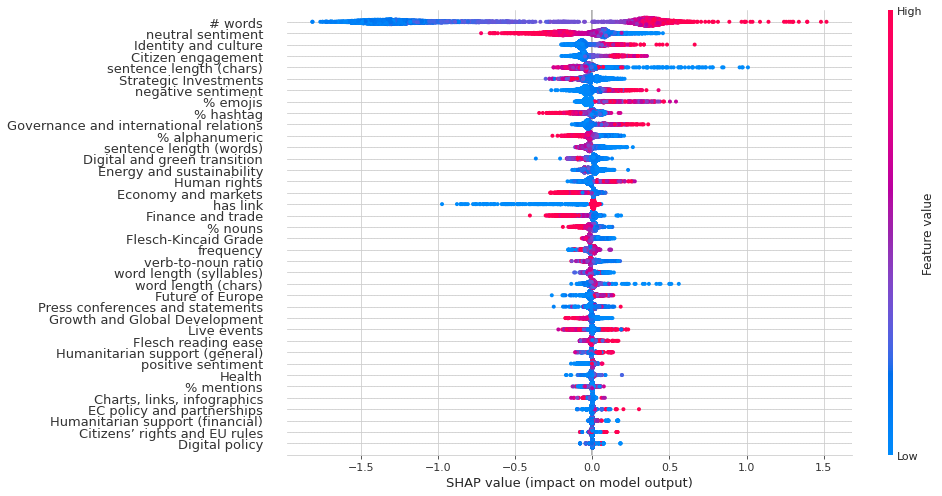

In [36]:
with xgboost.config_context(verbosity=0):
    for metric in ['sum']:
        print(f'***** {metric} *****')
        fnames = glob.glob(f'logs/engagement/{metric}_count/{metric}_count_*.pkl')
        for m in [f for f in fnames if 'combined' in f]:
            name = m.split('/')[-1]
            model = pkl.load(open(m, 'rb'))
            print(m)
            if 'topic' in m:
                feature_names = topic_col
            elif 'style_short' in m:
                feature_names = style_short
            elif 'style_full' in m:
                feature_names = style_targets
            elif 'combined' in m:
                feature_names = topic_col + emotion_col + style_targets 
            elif 'sentiment' in m:
                feature_names = emotion_col
            else:
                bow_nr = m.split('_')[-1].split('.')[0]
                tokenizer = pkl.load(open(f'logs/engagement/{metric}_count/tokenizer_bow-{bow_nr}.pkl',
                                          'rb'))
                feature_names = tokenizer.get_feature_names()
                
            df = pd.DataFrame(zip(model.feature_importances_,
                                  feature_names), 
                              columns=['importance', 'feature'])
            df = df.sort_values(by='importance')
            #plt.subplots(figsize=(20,5))
            #sns.barplot(data=df, x='feature', y='importance', color='darkgrey')
            #plt.xticks(rotation=90)
            #plt.show()
            
            shaps = pkl.load(open(f'logs/engagement/{metric}_count/shap_{name}','rb'))
            if not 'topic' in m:
                df = df.tail(n=50)
                fig, ax = plt.subplots(figsize=(20,4))    
            shap.summary_plot(shaps, max_display=50, 
                              feature_names=feature_maps, 
                              plot_size=(14,7))

    

In [32]:
new_names_topic = ['Economy and markets', 'Finance and trade',
             'Strategic Investments', 'Health',
             "Citizens’ rights and EU rules", 'Digital policy',
             'Digital and green transition', 'Energy and sustainability',
             'Identity and culture', 'Future of Europe',
             'Citizen engagement', 'Governance and international relations',
             'EC policy and partnerships', 
             'Humanitarian support (general)', 'Humanitarian support (financial)',
             'Human rights', 'Growth and Global Development', 
             'Press conferences and statements',
             'Charts, links, infographics', 'Live events']
old_names = ['economy_and_markets', 'finance_and_trade',
             'investments_recovery_growth_and_innovation', 'health',
             'citizens_rights_and_regulations', 'digital_policy',
             'digital_and_green_transition', 'sustainability_energy_and_climate',
             'identity_and_culture', 'vision_for_the_future',
             'citizens_engagement_and_culture', 
             'governance_and_international_relations',
             'eu_policies_and_partnerships', 
             'humanitarian_support_and_refugees', 
             'humanitarian_financial_aid', 
             'human_rights', 'global_goals', 
             'press_conferences_and_statements', 
             'charts_links_and_infographics', 
             'live_events']

In [33]:
topicmap = dict(zip(old_names, new_names_topic))
stylemap = dict(zip(style_targets+sentiment_targets, new_names))
feature_maps = [topicmap[f] if f in topicmap.keys() else stylemap[f] for f in feature_names]